## Data Preprocessing


The data is stored in the [NetCDF](https://en.wikipedia.org/wiki/NetCDF) files with _.nc_ extension. One of the distinct features of this format is the **named** specification to the coordinates and the data variables. 

As shown below, we first merge all the yearly NetCDF files, and display the structure of the format. xarray library is used to read the NetCDF files. It allows the users to manipulate data based on more informative labels instead of integer location. 



In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
from climate_learn.utils.data import load_dataset, view

# path = "/content/drive/MyDrive/Climate/.climate_learn/data/weatherbench/era5/5.625/2m_temperature"
path = "/data0/datasets/weatherbench/data/weatherbench/era5/5.625deg/total_precipitation"
dataset = load_dataset(path)
view(dataset)

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 350633)
Coordinates:
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * time     (time) datetime64[ns] 1979-01-01T07:00:00 ... 2018-12-31T23:00:00
Data variables:
    tp       (time, lat, lon) float32 dask.array<chunksize=(8753, 32, 64), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2020-01-01 16:44:41 GMT by grib_to_netcdf-2.15.0: /opt/ecmw...

In [13]:
from climate_learn.utils.datetime import Year, Days, Hours
from climate_learn.data import DataModule

data_module = DataModule(
    dataset = "ERA5",
    task = "forecasting",
    root_dir = "/data0/datasets/weatherbench/data/weatherbench/era5/5.625deg",
    in_vars = ["2m_temperature"],
    out_vars = ["2m_temperature"],
    train_start_year = Year(1979),
    val_start_year = Year(2015),
    test_start_year = Year(2017),
    end_year = Year(2018),
    pred_range = Days(3),
    subsample = Hours(6),
    batch_size = 128,
    num_workers = 1
)

Creating train dataset


  0%|          | 0/36 [00:00<?, ?it/s]

Creating val dataset


  0%|          | 0/2 [00:00<?, ?it/s]

Creating test dataset


  0%|          | 0/2 [00:00<?, ?it/s]

In [14]:
!ls /data0/datasets/weatherbench/data/weatherbench/era5/5.625deg

10m_u_component_of_wind  geopotential_500     toa_incident_solar_radiation
10m_v_component_of_wind  potential_vorticity  total_cloud_cover
2m_temperature		 relative_humidity    total_precipitation
constants		 specific_humidity    u_component_of_wind
constants.nc		 temperature	      v_component_of_wind
geopotential		 temperature_850      vorticity


In [19]:
from climate_learn.models import load_model

# model_kwargs = {
#     "img_size": [32, 64],
#     "patch_size": 2,
#     "drop_path": 0.1,
#     "drop_rate": 0.1,
#     "learn_pos_emb": True,
#     "in_vars": data_module.hparams.in_vars,
#     "out_vars": data_module.hparams.out_vars,
#     "embed_dim": 128,
#     "depth": 8,
#     "decoder_depth": 0,
#     "num_heads": 4,
#     "mlp_ratio": 4,
# }

model_kwargs = {
    "in_channels": len(data_module.hparams.in_vars),
    "out_channels": len(data_module.hparams.out_vars),
    "n_blocks": 4,
    "prob_type": 'categorical'
}

optim_kwargs = {
    "lr": 1e-4,
    "weight_decay": 1e-5,
    "warmup_epochs": 1,
    "max_epochs": 5,
}

# model_module = load_model(name = "vit", task = "forecasting", model_kwargs = model_kwargs, optim_kwargs = optim_kwargs)
model_module = load_model(name = "resnet", task = "forecasting", model_kwargs = model_kwargs, optim_kwargs = optim_kwargs)
# model_module = load_model(name = "unet", task = "forecasting", model_kwargs = model_kwargs, optim_kwargs = optim_kwargs)

In [20]:
# add_description
from climate_learn.models import set_climatology
set_climatology(model_module, data_module)

In [21]:
from climate_learn.training import Trainer, WandbLogger

trainer = Trainer(
    seed = 0,
    accelerator = "gpu",
    precision = 16,
    max_epochs = 5,
    # logger = WandbLogger(project = "climate_learn", name = "forecast-vit")
)

In [22]:
trainer.fit(model_module, data_module)

┏━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃    ┃ Name                       ┃ Type              ┃ Params ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0  │ net                        │ ResNet            │  1.5 M │
│ 1  │ net.activation             │ LeakyReLU         │      0 │
│ 2  │ net.image_proj             │ PeriodicConv2D    │  6.4 K │
│ 3  │ net.image_proj.padding     │ PeriodicPadding2D │      0 │
│ 4  │ net.image_proj.conv        │ Conv2d            │  6.4 K │
│ 5  │ net.blocks                 │ ModuleList        │  1.2 M │
│ 6  │ net.blocks.0               │ ResidualBlock     │  295 K │
│ 7  │ net.blocks.0.activation    │ LeakyReLU         │      0 │
│ 8  │ net.blocks.0.conv1         │ PeriodicConv2D    │  147 K │
│ 9  │ net.blocks.0.conv1.padding │ PeriodicPadding2D │      0 │
│ 10 │ net.blocks.0.conv1.conv    │ Conv2d            │  147 K │
│ 11 │ net.blocks.0.conv2         │ PeriodicConv2D    │  147 K │
│ 12 │ net.blocks.0.conv2.padding │ PeriodicPadding2D │      0 │
│ 13 │ net.blocks.0.conv2.conv    │ Conv2d            │  147 K │
│ 14 │ net.blocks.0.shortcut      │ Identity          │      0 │
│ 15 │ net.blocks.0.norm1         │ BatchNorm2d       │    256 │
│ 16 │ net.blocks.0.norm2         │ BatchNorm2d       │    256 │
│ 17 │ net.blocks.0.drop          │ Dropout           │      0 │
│ 18 │ net.blocks.1               │ ResidualBlock     │  295 K │
│ 19 │ net.blocks.1.activation    │ LeakyReLU         │      0 │
│ 20 │ net.blocks.1.conv1         │ PeriodicConv2D    │  147 K │
│ 21 │ net.blocks.1.conv1.padding │ PeriodicPadding2D │      0 │
│ 22 │ net.blocks.1.conv1.conv    │ Conv2d            │  147 K │
│ 23 │ net.blocks.1.conv2         │ PeriodicConv2D    │  147 K │
│ 24 │ net.blocks.1.conv2.padding │ PeriodicPadding2D │      0 │
│ 25 │ net.blocks.1.conv2.conv    │ Conv2d            │  147 K │
│ 26 │ net.blocks.1.shortcut      │ Identity          │      0 │
│ 27 │ net.blocks.1.norm1         │ BatchNorm2d       │    256 │
│ 28 │ net.blocks.1.norm2         │ BatchNorm2d       │    256 │
│ 29 │ net.blocks.1.drop          │ Dropout           │      0 │
│ 30 │ net.blocks.2               │ ResidualBlock     │  295 K │
│ 31 │ net.blocks.2.activation    │ LeakyReLU         │      0 │
│ 32 │ net.blocks.2.conv1         │ PeriodicConv2D    │  147 K │
│ 33 │ net.blocks.2.conv1.padding │ PeriodicPadding2D │      0 │
│ 34 │ net.blocks.2.conv1.conv    │ Conv2d            │  147 K │
│ 35 │ net.blocks.2.conv2         │ PeriodicConv2D    │  147 K │
│ 36 │ net.blocks.2.conv2.padding │ PeriodicPadding2D │      0 │
│ 37 │ net.blocks.2.conv2.conv    │ Conv2d            │  147 K │
│ 38 │ net.blocks.2.shortcut      │ Identity          │      0 │
│ 39 │ net.blocks.2.norm1         │ BatchNorm2d       │    256 │
│ 40 │ net.blocks.2.norm2         │ BatchNorm2d       │    256 │
│ 41 │ net.blocks.2.drop          │ Dropout           │      0 │
│ 42 │ net.blocks.3               │ ResidualBlock     │  295 K │
│ 43 │ net.blocks.3.activation    │ LeakyReLU         │      0 │
│ 44 │ net.blocks.3.conv1         │ PeriodicConv2D    │  147 K │
│ 45 │ net.blocks.3.conv1.padding │ PeriodicPadding2D │      0 │
│ 46 │ net.blocks.3.conv1.conv    │ Conv2d            │  147 K │
│ 47 │ net.blocks.3.conv2         │ PeriodicConv2D    │  147 K │
│ 48 │ net.blocks.3.conv2.padding │ PeriodicPadding2D │      0 │
│ 49 │ net.blocks.3.conv2.conv    │ Conv2d            │  147 K │
│ 50 │ net.blocks.3.shortcut      │ Identity          │      0 │
│ 51 │ net.blocks.3.norm1         │ BatchNorm2d       │    256 │
│ 52 │ net.blocks.3.norm2         │ BatchNorm2d       │    256 │
│ 53 │ net.blocks.3.drop          │ Dropout           │      0 │
│ 54 │ net.norm                   │ BatchNorm2d       │    256 │
│ 55 │ net.final                  │ PeriodicConv2D    │  313 K │
│ 56 │ net.final.padding          │ PeriodicPadding2D │      0 │
│ 57 │ net.final.conv             │ Conv2d            │  313 K │
│ 58 │ denormalization            │

Trainable params: 1.5 M                                                                      
Non-trainable params: 0                                                                      
Total params: 1.5 M                                                                          
Total estimated model params size (MB): 3

Output()

/home/tang/miniconda3/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/trainer/conn
ectors/data_connector.py:241: PossibleUserWarning: The dataloader, train_dataloader, does not
have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` (try 64 which is the number of cpus on this machine) in the 
`DataLoader` init to improve performance.
  category=PossibleUserWarning,

## Evaluation 


In [23]:
trainer.test(model_module, data_module)

Output()

/home/tang/miniconda3/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:241: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                 Test metric                 ┃                DataLoader 0                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                  test/loss                  │              3.897252313997153              │
│      test/w_categorical_2m_temperature      │              3.897252313997153              │
│ test_climatology_baseline/w_rmse_2m_temper… │              16.72373141497188              │
└─────────────────────────────────────────────┴─────────────────────────────────────────────┘

## Visualization 

We visualize the **bias**, given by the difference in the predicted and the ground truth values, to better analyze our learned model.

Visualization is done on the test set. We can either specify exact time for the initial condition, or randomly sample from the test set.

torch.Size([1, 1, 32, 64])
torch.Size([1, 32, 64])
torch.Size([1, 50, 1, 32, 64])


TypeError: Invalid shape (50, 32, 64) for image data

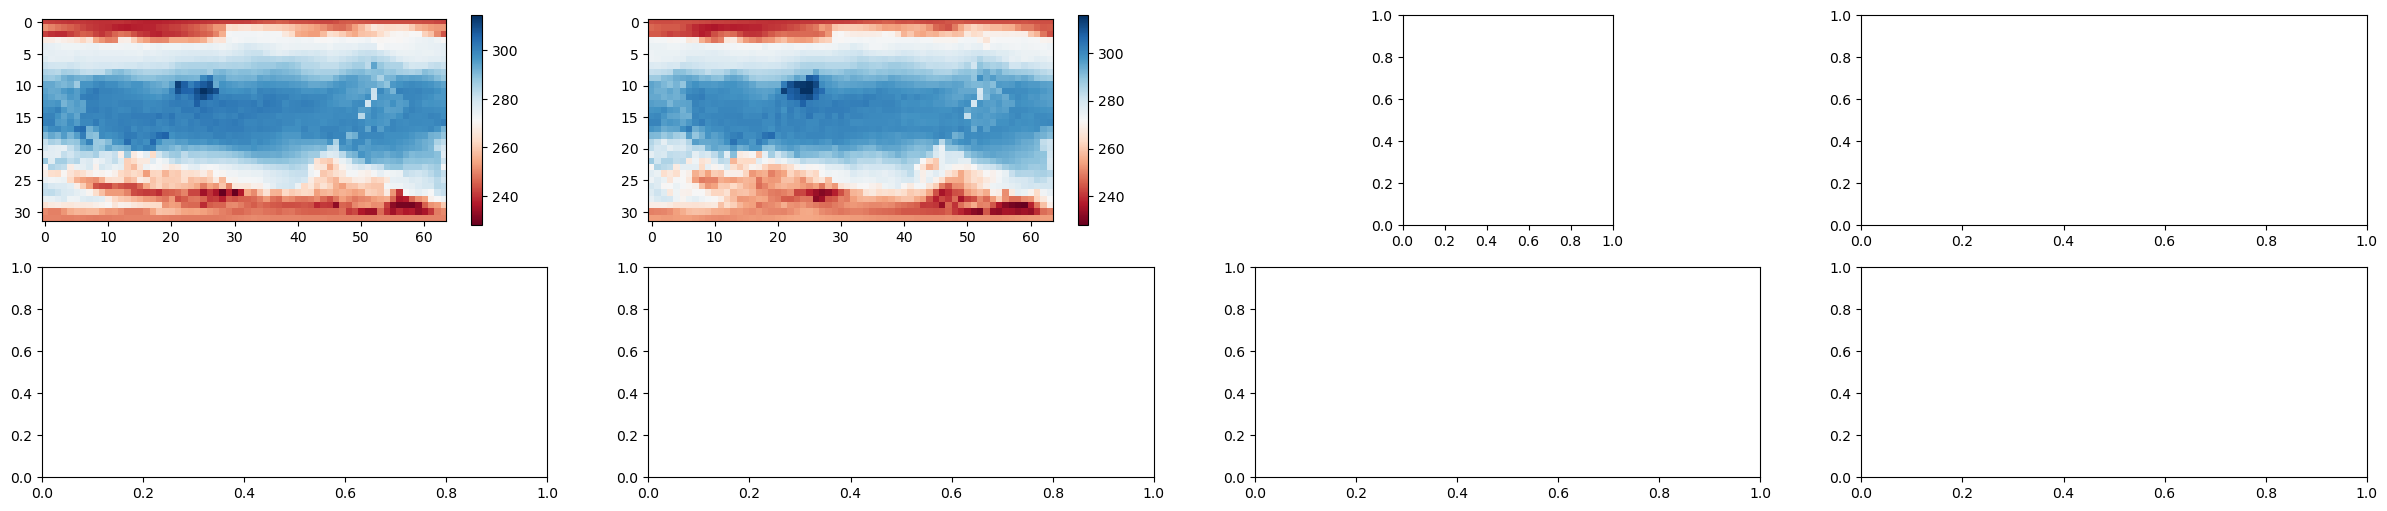

In [25]:
# from climate_learn.utils import visualize

import os
import random
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

def visualize(model_module, data_module, split = "test", samples = 2, save_dir = None):
    if save_dir is not None:
        os.makedirs(save_dir, exist_ok = True)

    # dataset.setup()
    dataset = eval(f"data_module.{split}_dataset")

    if(type(samples) == int):
        idxs = random.sample(range(0, len(dataset)), samples)
    elif(type(samples) == list):
        idxs = [np.searchsorted(dataset.time, np.datetime64(datetime.strptime(dt, "%Y-%m-%d:%H"))) for dt in samples]
    else:
        raise Exception("Invalid type for samples; Allowed int or list[datetime.datetime or np.datetime64]")

    fig, axes = plt.subplots(len(idxs), 4, figsize=(30, 3 * len(idxs)), squeeze = False)

    for index, idx in enumerate(idxs):
        x, y, _, _ = dataset[idx] # 1, 1, 32, 64
        pred = model_module.forward(x.unsqueeze(0)) # 1, 1, 32, 64

        inv_normalize = model_module.denormalization
        init_condition, gt = inv_normalize(x), inv_normalize(y)
        pred = inv_normalize(pred)
        bias = pred - gt

        for i, tensor in enumerate([init_condition, gt, pred, bias]):
            ax = axes[index][i]
            print(tensor.shape)
            im = ax.imshow(tensor.detach().squeeze().cpu().numpy())
            im.set_cmap(cmap=plt.cm.RdBu)
            fig.colorbar(im, ax=ax)

        if(data_module.hparams.task == "forecasting"):
            axes[index][0].set_title("Initial condition [Kelvin]")
            axes[index][1].set_title("Ground truth [Kelvin]")
            axes[index][2].set_title("Prediction [Kelvin]")
            axes[index][3].set_title("Bias [Kelvin]")
        elif(data_module.hparams.task == "downscaling"):
            axes[index][0].set_title("Low resolution data [Kelvin]")
            axes[index][1].set_title("High resolution data [Kelvin]")
            axes[index][2].set_title("Downscaled [Kelvin]")
            axes[index][3].set_title("Bias [Kelvin]")
        else:
            raise NotImplementedError

    fig.tight_layout()
    
    if save_dir is not None:
        plt.savefig(os.path.join(save_dir, 'visualize.png'))
    else:
        plt.show()

# if samples = 2, we randomly pick 2 initial conditions in the test set
visualize(model_module, data_module, samples = ["2017-06-01:12", "2017-08-01:18"])

In [ ]:
import torch
from tqdm import tqdm

def visualize_mean_bias(model_module, data_module, save_dir = None):
    if save_dir is not None:
        os.makedirs(save_dir, exist_ok = True)

    loader = data_module.test_dataloader()

    all_mean_bias = []
    for batch in tqdm(loader):
        x, y, _, _ = batch # B, 1, 32, 64
        x = x.to(model_module.device)
        y = y.to(model_module.device)
        pred = model_module.forward(x) # B, 1, 32, 64

        inv_normalize = model_module.denormalization
        init_condition, gt = inv_normalize(x), inv_normalize(y)
        pred = inv_normalize(pred)
        bias = pred - gt # B, 1, 32, 64
        mean_bias = bias.mean(dim=0)
        all_mean_bias.append(mean_bias)
    
    all_mean_bias = torch.stack(all_mean_bias, dim=0)
    mean_bias = torch.mean(all_mean_bias, dim=0)

    fig, axes = plt.subplots(1, 1, figsize=(12, 4), squeeze = False)
    ax = axes[0,0]

    im = ax.imshow(mean_bias.detach().squeeze().cpu().numpy())
    im.set_cmap(cmap=plt.cm.RdBu)
    fig.colorbar(im, ax=ax)
    ax.set_title("Mean bias [Kelvin]")

    fig.tight_layout()
    
    if save_dir is not None:
        plt.savefig(os.path.join(save_dir, 'visualize_mean_bias.png'))
    else:
        plt.show()

visualize_mean_bias(model_module.cuda(), data_module)

In [ ]:
from climate_learn.utils.datetime import Year, Days, Hours
from climate_learn.data import DataModule

data_module = DataModule(
    dataset = "ERA5",
    task = "downscaling",
    root_dir = "/data0/datasets/weatherbench/data/weatherbench/era5/5.625deg/",
    root_highres_dir = "/data0/datasets/weatherbench/data/weatherbench/era5/2.8125deg/",
    in_vars = ["2m_temperature"],
    out_vars = ["2m_temperature"],
    train_start_year = Year(1979),
    val_start_year = Year(2015),
    test_start_year = Year(2017),
    end_year = Year(2018),
    subsample = Hours(6),
    batch_size = 128,
    num_workers = 1
)

## Model initialization

In [ ]:
from climate_learn.models import load_model

# model_kwargs = {
#     "img_size": [32, 64],
#     "patch_size": 4,
#     "drop_path": 0.1,
#     "drop_rate": 0.1,
#     "learn_pos_emb": True,
#     "in_vars": data_module.hparams.in_vars,
#     "out_vars": data_module.hparams.out_vars,
#     "upsampling": data_module.train_dataset.downscale_ratio,
#     "embed_dim": 128,
#     "depth": 8,
#     "decoder_depth": 0,
#     "num_heads": 4,
#     "mlp_ratio": 4,
# }

model_kwargs = {
    "in_channels": len(data_module.hparams.in_vars),
    "out_channels": len(data_module.hparams.out_vars),
    "upsampling": data_module.train_dataset.downscale_ratio,
    "n_blocks": 4,
}

optim_kwargs = {
    "optimizer": "adamw",
    "lr": 1e-4,
    "weight_decay": 1e-5,
    "warmup_epochs": 1,
    "max_epochs": 5,
}

# model_module = load_model(name = "vit", task = "downscaling", model_kwargs = model_kwargs, optim_kwargs = optim_kwargs)
model_module = load_model(name = "resnet", task = "downscaling", model_kwargs = model_kwargs, optim_kwargs = optim_kwargs)
# model_module = load_model(name = "unet", task = "downscaling", model_kwargs = model_kwargs, optim_kwargs = optim_kwargs)

In [ ]:
# latitude long info, 
from climate_learn.models import set_climatology
set_climatology(model_module, data_module)

## Training

In [ ]:
from climate_learn.training import Trainer, WandbLogger

trainer = Trainer(
    seed = 0,
    accelerator = "gpu",
    precision = 16,
    max_epochs = 5,
    # logger = WandbLogger(project = "climate_learn", name = "downscale-vit")
)

In [ ]:
trainer.fit(model_module, data_module)

## Evaluation

In [ ]:
trainer.test(model_module, data_module)

## Visualization 

In [ ]:
# from climate_learn.utils import visualize
# visualize(model_module, data_module)
visualize(model_module, data_module, samples = ["2017-06-01:12", "2017-08-01:18"])